# Google Vertex AI Vector Search

This notebook shows how to use functionality related to the `Google Cloud Vertex AI Vector Search` vector database.

> [Google Vertex AI Vector Search](https://cloud.google.com/vertex-ai/docs/vector-search/overview), formerly known as Vertex AI Matching Engine, provides the industry's leading high-scale low latency vector database. These vector databases are commonly referred to as vector similarity-matching or an approximate nearest neighbor (ANN) service.

**Note**: Langchain API expects an endpoint and deployed index already created.Index creation time can take upto one hour.

> To see how to create an index refer to the section [Create Index and deploy it to an Endpoint](#create-index-and-deploy-it-to-an-endpoint)  
If you already have an index deployed , skip to [Create VectorStore from texts](#create-vector-store-from-texts)

## Create Index and deploy it to an Endpoint
- This section demonstrates creating a new index and deploying it to an endpoint

In [ ]:
# TODO : Set values as per your requirements
# Project and Storage Constants
PROJECT_ID = "<my_project_id>"
REGION = "<my_region>"
BUCKET = "<my_gcs_bucket>"
BUCKET_URI = f"gs://{BUCKET}"

# The number of dimensions for the textembedding-gecko@003 is 768
# If other embedder is used, the dimensions would probably need to change.
DIMENSIONS = 768

# Index Constants
DISPLAY_NAME = "<my_matching_engine_index_id>"
DEPLOYED_INDEX_ID = "<my_matching_engine_endpoint_id>"

In [ ]:
# Create a bucket.
! gsutil mb -l $REGION -p $PROJECT_ID $BUCKET_URI

### Use [VertexAIEmbeddings](https://python.langchain.com/docs/integrations/text_embedding/google_vertex_ai_palm/) as the embeddings model

In [2]:
from google.cloud import aiplatform
from langchain_google_vertexai import VertexAIEmbeddings

In [ ]:
aiplatform.init(project=PROJECT_ID, location=REGION, staging_bucket=BUCKET_URI)

In [2]:
embedding_model = VertexAIEmbeddings(model_name="text-embedding-005")

### Create an empty Index 

**Note :** While creating an index you should specify an "index_update_method" from either a "BATCH_UPDATE" or "STREAM_UPDATE"
> A batch index is for when you want to update your index in a batch, with data which has been stored over a set amount of time, like systems which are processed weekly or monthly. A streaming index is when you want index data to be updated as new data is added to your datastore, for instance, if you have a bookstore and want to show new inventory online as soon as possible. Which type you choose is important, since setup and requirements are different.

Refer [Official Documentation](https://cloud.google.com/vertex-ai/docs/vector-search/create-manage-index#create-index-batch) for more details on configuring indexes


In [ ]:
# NOTE : This operation can take upto 30 seconds
my_index = aiplatform.MatchingEngineIndex.create_tree_ah_index(
    display_name=DISPLAY_NAME,
    dimensions=DIMENSIONS,
    approximate_neighbors_count=150,
    distance_measure_type="DOT_PRODUCT_DISTANCE",
    index_update_method="STREAM_UPDATE",  # allowed values BATCH_UPDATE , STREAM_UPDATE
)

### Create an Endpoint

In [ ]:
# Create an endpoint
my_index_endpoint = aiplatform.MatchingEngineIndexEndpoint.create(
    display_name=f"{DISPLAY_NAME}-endpoint", public_endpoint_enabled=True
)

### Deploy Index to the Endpoint

In [ ]:
# NOTE : This operation can take upto 20 minutes
my_index_endpoint = my_index_endpoint.deploy_index(
    index=my_index, deployed_index_id=DEPLOYED_INDEX_ID
)

my_index_endpoint.deployed_indexes

## Create Vector Store from texts

NOTE : If you have existing Index and Endpoints, you can load them using below code

In [ ]:
# TODO : replace 1234567890123456789 with your acutial index ID
my_index = aiplatform.MatchingEngineIndex("1234567890123456789")

# TODO : replace 1234567890123456789 with your acutial endpoint ID
my_index_endpoint = aiplatform.MatchingEngineIndexEndpoint("1234567890123456789")

In [ ]:
from langchain_google_vertexai import (
    VectorSearchVectorStore,
    VectorSearchVectorStoreDatastore,
)

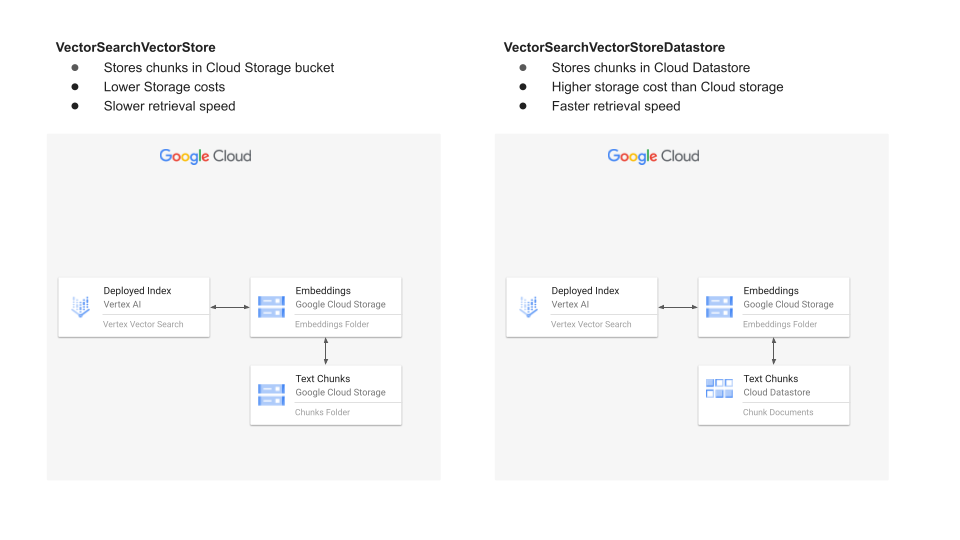

### Create simple vectorstore ( without filters)

In [ ]:
# Input texts
texts = [
    "The cat sat on",
    "the mat.",
    "I like to",
    "eat pizza for",
    "dinner.",
    "The sun sets",
    "in the west.",
]

# Create a Vector Store
vector_store = VectorSearchVectorStore.from_components(
    project_id=PROJECT_ID,
    region=REGION,
    gcs_bucket_name=BUCKET,
    index_id=my_index.name,
    endpoint_id=my_index_endpoint.name,
    embedding=embedding_model,
    stream_update=True,
)

# Add vectors and mapped text chunks to your vectore store
vector_store.add_texts(texts=texts)

### OPTIONAL : You can also create vectore and store chunks in a Datastore 

In [ ]:
# NOTE : This operation can take upto 20 mins
vector_store = VectorSearchVectorStoreDatastore.from_components(
    project_id=PROJECT_ID,
    region=REGION,
    index_id=my_index.name,
    endpoint_id=my_index_endpoint.name,
    embedding=embedding_model,
    stream_update=True,
)

vector_store.add_texts(texts=texts, is_complete_overwrite=True)

In [ ]:
# Try running a simialarity search
vector_store.similarity_search("pizza")

### Create vectorstore with metadata filters

In [ ]:
# Input text with metadata
record_data = [
    {
        "description": "A versatile pair of dark-wash denim jeans."
        "Made from durable cotton with a classic straight-leg cut, these jeans"
        " transition easily from casual days to dressier occasions.",
        "price": 65.00,
        "color": "blue",
        "season": ["fall", "winter", "spring"],
    },
    {
        "description": "A lightweight linen button-down shirt in a crisp white."
        " Perfect for keeping cool with breathable fabric and a relaxed fit.",
        "price": 34.99,
        "color": "white",
        "season": ["summer", "spring"],
    },
    {
        "description": "A soft, chunky knit sweater in a vibrant forest green. "
        "The oversized fit and cozy wool blend make this ideal for staying warm "
        "when the temperature drops.",
        "price": 89.99,
        "color": "green",
        "season": ["fall", "winter"],
    },
    {
        "description": "A classic crewneck t-shirt in a soft, heathered blue. "
        "Made from comfortable cotton jersey, this t-shirt is a wardrobe essential "
        "that works for every season.",
        "price": 19.99,
        "color": "blue",
        "season": ["fall", "winter", "summer", "spring"],
    },
    {
        "description": "A flowing midi-skirt in a delicate floral print. "
        "Lightweight and airy, this skirt adds a touch of feminine style "
        "to warmer days.",
        "price": 45.00,
        "color": "white",
        "season": ["spring", "summer"],
    },
]

In [ ]:
# Parse and prepare input data

texts = []
metadatas = []
for record in record_data:
    record = record.copy()
    page_content = record.pop("description")
    texts.append(page_content)
    if isinstance(page_content, str):
        metadata = {**record}
        metadatas.append(metadata)

In [ ]:
# Inspect metadatas
metadatas

In [ ]:
# NOTE : This operation can take more than 20 mins
vector_store = VectorSearchVectorStore.from_components(
    project_id=PROJECT_ID,
    region=REGION,
    gcs_bucket_name=BUCKET,
    index_id=my_index.name,
    endpoint_id=my_index_endpoint.name,
    embedding=embedding_model,
)

vector_store.add_texts(texts=texts, metadatas=metadatas, is_complete_overwrite=True)

In [ ]:
from google.cloud.aiplatform.matching_engine.matching_engine_index_endpoint import (
    Namespace,
    NumericNamespace,
)

In [ ]:
# Try running a simple similarity search

# Below code should return 5 results
vector_store.similarity_search("shirt", k=5)

In [ ]:
# Try running a similarity search with text filter
filters = [Namespace(name="season", allow_tokens=["spring"])]

# Below code should return 4 results now
vector_store.similarity_search("shirt", k=5, filter=filters)

In [ ]:
# Try running a similarity search with combination of text and numeric filter
filters = [Namespace(name="season", allow_tokens=["spring"])]
numeric_filters = [NumericNamespace(name="price", value_float=40.0, op="LESS")]

# Below code should return 2 results now
vector_store.similarity_search(
    "shirt", k=5, filter=filters, numeric_filter=numeric_filters
)

### Use Vector Store as retriever

In [ ]:
# Initialize the vectore_store as retriever
retriever = vector_store.as_retriever()

In [ ]:
# perform simple similarity search on retriever
retriever.invoke("What are my options in breathable fabric?")

In [ ]:
# Try running a similarity search with text filter
filters = [Namespace(name="season", allow_tokens=["spring"])]

retriever.search_kwargs = {"filter": filters}

# perform similarity search with filters on retriever
retriever.invoke("What are my options in breathable fabric?")

In [ ]:
# Try running a similarity search with combination of text and numeric filter
filters = [Namespace(name="season", allow_tokens=["spring"])]
numeric_filters = [NumericNamespace(name="price", value_float=40.0, op="LESS")]


retriever.search_kwargs = {"filter": filters, "numeric_filter": numeric_filters}

retriever.invoke("What are my options in breathable fabric?")

### Use filters with retriever in Question Answering Chains

In [ ]:
from langchain_google_vertexai import VertexAI

llm = VertexAI(model_name="gemini-pro")

In [ ]:
from langchain.chains import RetrievalQA

filters = [Namespace(name="season", allow_tokens=["spring"])]
numeric_filters = [NumericNamespace(name="price", value_float=40.0, op="LESS")]

retriever.search_kwargs = {"k": 2, "filter": filters, "numeric_filter": numeric_filters}

retrieval_qa = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=retriever,
    return_source_documents=True,
)

question = "What are my options in breathable fabric?"
response = retrieval_qa({"query": question})
print(f"{response['result']}")
print("REFERENCES")
print(f"{response['source_documents']}")

## Read , Chunk , Vectorise and Index PDFs

In [ ]:
!pip install pypdf

In [ ]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [ ]:
loader = PyPDFLoader("https://arxiv.org/pdf/1706.03762.pdf")
pages = loader.load()

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size=1000,
    chunk_overlap=20,
    length_function=len,
    is_separator_regex=False,
)
doc_splits = text_splitter.split_documents(pages)

In [ ]:
texts = [doc.page_content for doc in doc_splits]
metadatas = [doc.metadata for doc in doc_splits]

In [ ]:
texts[0]

In [ ]:
# Inspect Metadata of 1st page
metadatas[0]

In [ ]:
vector_store = VectorSearchVectorStore.from_components(
    project_id=PROJECT_ID,
    region=REGION,
    gcs_bucket_name=BUCKET,
    index_id=my_index.name,
    endpoint_id=my_index_endpoint.name,
    embedding=embedding_model,
)

vector_store.add_texts(texts=texts, metadatas=metadatas, is_complete_overwrite=True)

In [ ]:
vector_store = VectorSearchVectorStore.from_components(
    project_id=PROJECT_ID,
    region=REGION,
    gcs_bucket_name=BUCKET,
    index_id=my_index.name,
    endpoint_id=my_index_endpoint.name,
    embedding=embedding_model,
)

## Hybrid Search

Vector Search supports hybrid search, a popular architecture pattern in information retrieval (IR) that combines both semantic search and keyword search (also called token-based search). With hybrid search, developers can take advantage of the best of the two approaches, effectively providing higher search quality.
Click [here](https://cloud.google.com/vertex-ai/docs/vector-search/about-hybrid-search) to learn more.

In order to use hybrid search, we need to fit a sparse embedding vectorizer and handle the embeddings outside of the Vector Search integration.
An example of sparse embedding vectorizer is sklearn TfidfVectorizer but other techniques can be used, for instance BM25.

In [16]:
# Define some sample data
texts = [
    "The cat sat on",
    "the mat.",
    "I like to",
    "eat pizza for",
    "dinner.",
    "The sun sets",
    "in the west.",
]

# optional IDs
ids = ["i_" + str(i + 1) for i in range(len(texts))]

# optional metadata
metadatas = [{"my_metadata": i} for i in range(len(texts))]

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Fit the TFIDF Vectorizer (This is usually done on a very large corpus of data to make sure that word statistics generalize well on new data)
vectorizer = TfidfVectorizer()
vectorizer.fit(texts)

In [ ]:
# Utility function to transform text into a TF-IDF Sparse Vector
def get_sparse_embedding(tfidf_vectorizer, text):
    tfidf_vector = tfidf_vectorizer.transform([text])
    values = []
    dims = []
    for i, tfidf_value in enumerate(tfidf_vector.data):
        values.append(float(tfidf_value))
        dims.append(int(tfidf_vector.indices[i]))
    return {"values": values, "dimensions": dims}

In [19]:
# semantic (dense) embeddings
embeddings = embedding_model.embed_documents(texts)
# tfidf (sparse) embeddings
sparse_embeddings = [get_sparse_embedding(vectorizer, x) for x in texts]

In [ ]:
sparse_embeddings[0]

In [ ]:
# Add the dense and sparse embeddings in Vector Search

vector_store.add_texts_with_embeddings(
    texts=texts,
    embeddings=embeddings,
    sparse_embeddings=sparse_embeddings,
    ids=ids,
    metadatas=metadatas,
)

In [ ]:
# Run hybrid search
query = "the cat"
embedding = embedding_model.embed_query(query)
sparse_embedding = get_sparse_embedding(vectorizer, query)

vector_store.similarity_search_by_vector_with_score(
    embedding=embedding,
    sparse_embedding=sparse_embedding,
    k=5,
    rrf_ranking_alpha=0.7,  # 0.7 weight to dense and 0.3 weight to sparse
)